In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 제출 파일 생성 관련
import os
import zipfile

# 데이터 처리 및 분석
import pandas as pd
import numpy as np
from scipy import stats
from tqdm import tqdm

# To ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 데이터 불러오기
path = '/content/drive/MyDrive/Colab Notebooks/fsi/open/'
save_path = '/content/drive/MyDrive/Colab Notebooks/fsi/processed_data/1_all_pre_syn.csv'

train_all = pd.read_csv(path + "train.csv")
test_all = pd.read_csv(path + "test.csv")
saved_train = pd.read_csv(save_path)

save_path = '/content/drive/MyDrive/Colab Notebooks/fsi/processed_data'
all_synthetic_data = pd.read_csv(save_path + '/ctgan_syn_data.csv')

train = train_all.drop(columns="ID")
saved_train["Fraud_Type"].value_counts()

,count
Fraud_Type,
m,118800
a,100
j,100
h,100
k,100
c,100
g,100
i,100
b,100


In [ ]:
# 설치

In [ ]:
!pip install catboost

In [ ]:
!pip install sdv

In [ ]:
!pip install sdmetrics

# 통계적 관점

In [ ]:
from sdv.metadata import SingleTableMetadata

# 메타 데이터 타입 설정
column_sdtypes = {
        'Account_amount_daily_limit': 'numerical',
        'Transaction_num_connection_failure': 'numerical',
        'Number_of_transaction_with_the_account': 'numerical',
        'Transaction_history_with_the_account': 'numerical',
        'Account_initial_balance': 'numerical',
        'Account_balance': 'numerical',
        'Customer_identification_number': 'categorical',
        'Customer_personal_identifier': 'categorical',
        'Account_account_number': 'categorical',
        'IP_Address': 'ipv4_address',
        'Location': 'categorical',
        'Recipient_Account_Number': 'categorical',
        'Fraud_Type': 'categorical',
        'Customer_Birthyear': 'numerical'
    }

fraud_type = 'a'
subset = saved_train[saved_train["Fraud_Type"] == fraud_type]
syn_subset = all_synthetic_data[all_synthetic_data["Fraud_Type"] == fraud_type]
subset = subset.drop('Time_difference_seconds', axis=1)

# 메타데이터 생성 및 모델 학습
metadata = SingleTableMetadata()

metadata.detect_from_dataframe(subset)
metadata.set_primary_key(None)

# 각 컬럼에 대해 데이터 타입 설정
for column, sdtype in column_sdtypes.items():
    metadata.update_column(
        column_name=column,
        sdtype=sdtype
    )

In [ ]:
from sdmetrics.reports.single_table import DiagnosticReport
from sdmetrics.reports.single_table import QualityReport

types = saved_train.Fraud_Type.unique()
statis = pd.DataFrame(types, columns=['Fraud_Type'])
statis['Data_Quality'] = 0
statis['Data_Diagnostic'] = 0
statis['Conti_statis'] = 0
statis['Cate_statis'] = 0

for x in types:
    if x == 'm':
        continue
    subset = saved_train[saved_train["Fraud_Type"] == x]
    syn_subset = all_synthetic_data[all_synthetic_data["Fraud_Type"] == x]
    subset = subset.drop('Time_difference_seconds', axis=1)

    # 메타데이터 생성 및 모델 학습
    metadata = SingleTableMetadata()
    metadata.detect_from_dataframe(subset)
    metadata.set_primary_key(None)

    # 각 컬럼에 대해 데이터 타입 설정
    for column, sdtype in column_sdtypes.items():
        metadata.update_column(
            column_name=column,
            sdtype=sdtype)

    report_q = QualityReport()
    report_d = DiagnosticReport()

    metadata_as_dict = metadata.to_dict()
    report_q.generate(subset, syn_subset, metadata_as_dict)
    report_d.generate(subset, syn_subset, metadata_as_dict)

    statis.loc[statis['Fraud_Type'] == x, 'Data_Quality'] = report_q.get_score()
    statis.loc[statis['Fraud_Type'] == x, 'Data_Diagnostic'] = report_d.get_score()

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 63/63 [00:02<00:00, 22.83it/s]|
Column Shapes Score: 80.77%

(2/2) Evaluating Column Pair Trends: |██████████| 1953/1953 [07:27<00:00,  4.36it/s]|
Column Pair Trends Score: 66.55%

Overall Score (Average): 73.66%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 63/63 [00:00<00:00, 1081.08it/s]|
Data Validity Score: 98.13%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 127.47it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.06%

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 63/63 [00:02<00:00, 24.87it/s]|
Column Shapes Score: 78.67%

(2/2) Evaluating Column Pair Trends: |██████████| 1953/1953 [07:00<00:00,  4.64it/s]|
Column Pair Trends Score: 65.73%

Overall Score (Average): 72.2%

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 63/63 [00:00<00:00, 1237.10it/s]|
Data Validity Score: 98.46%

(2/2) Evaluating Data Structure: |█

In [ ]:
statis

,Fraud_Type,Data_Quality,Data_Diagnostic,Conti_statis,Cate_statis
0,m,0.000000,0.000000,0,0
1,a,0.736589,0.990633,0,0
2,j,0.722031,0.992279,0,0
3,h,0.755933,0.999602,0,0
4,k,0.728634,0.990335,0,0
5,c,0.742374,0.999398,0,0
6,g,0.747629,0.995837,0,0
7,i,0.744829,0.993115,0,0
8,b,0.763117,0.999047,0,0
9,f,0.771533,0.999959,0,0


In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sdmetrics.visualization import get_column_plot

# 시간 차이 계산
subset['Time_difference_seconds'] = pd.to_timedelta(subset['Time_difference']).dt.total_seconds()
syn_subset['Time_difference_seconds'] = pd.to_timedelta(syn_subset['Time_difference']).dt.total_seconds()

# 그래프에 추가할 컬럼 목록
columns = ['Transaction_Amount', 'Account_initial_balance', 'Account_balance',
           'Account_one_month_max_amount',
           'Account_one_month_std_dev', 'Account_dawn_one_month_max_amount',
           'Time_difference_seconds', 'Account_dawn_one_month_std_dev']

# 3x3 서브플롯 생성
fig = make_subplots(rows=3, cols=3, subplot_titles=columns)

# 각 컬럼에 대해 그래프 생성 및 서브플롯에 추가
for i, col in enumerate(columns):
    row = i // 3 + 1
    col_idx = i % 3 + 1

    # 각 컬럼에 대한 plotly figure 생성
    fig_ = get_column_plot(
        real_data=subset,
        synthetic_data=syn_subset,
        column_name=col,
        plot_type='distplot'
    )

    # 서브플롯에 그래프 추가
    for trace in fig_.data:
        fig.add_trace(trace, row=row, col=col_idx)

# 레이아웃 조정
fig.update_layout(
    height=900,
    width=1200,  # 가로 길이를 늘림
    title_text= x + ": Comparison of Distributions",
    title_font=dict(size=14)  # 제목 글씨 크기 조정
)

# 인터랙티브한 플롯 표시
fig.show()

In [ ]:
import numpy as np
from scipy.stats import entropy

def inverse_kld(p, q):
    """
    p와 q는 두 확률 분포입니다.
    """
    p = np.asarray(p, dtype=np.float64)
    q = np.asarray(q, dtype=np.float64)

    kld_pq = entropy(p, q)
    kld_qp = entropy(q, p)

    inv_kld = 0.5 * (kld_pq + kld_qp)

    return inv_kld

from scipy.spatial.distance import jensenshannon

def calculate_jsd(p, q, base=np.e, epsilon=1e-10):
    """
    두 확률 분포 p와 q 사이의 Jensen-Shannon Divergence를 계산합니다.
    p와 q는 각 요소가 대응되는 동일한 길이의 확률 분포여야 합니다.
    NaN을 방지하기 위해 epsilon 값을 추가하여 안정화합니다.
    """
    # 작은 값을 더해줌으로써 NaN 방지
    p = np.asarray(p, dtype=np.float64) + epsilon
    q = np.asarray(q, dtype=np.float64) + epsilon

    # 두 분포를 다시 확률 분포로 정상화 (합이 1이 되도록)
    p /= p.sum()
    q /= q.sum()

    # Jensen-Shannon Divergence 계산
    jsd = jensenshannon(p, q, base=base) ** 2  # 결과는 sqrt(JSD)로 반환되므로 제곱하여 JSD로 변환
    return jsd


# 그래프에 추가할 컬럼 목록
columns = ['Transaction_Amount', 'Account_initial_balance', 'Account_balance',
           'Account_remaining_amount_daily_limit_exceeded', 'Account_one_month_max_amount',
           'Account_one_month_std_dev', 'Account_dawn_one_month_max_amount',
           'Time_difference_seconds', 'Account_dawn_one_month_std_dev']

for x in types:
    col_score = 0
    col_cnt = 0
    print(x)
    subset = saved_train[saved_train["Fraud_Type"] == x]
    syn_subset = all_synthetic_data[all_synthetic_data["Fraud_Type"] == x]

    subset['Time_difference_seconds'] = pd.to_timedelta(subset['Time_difference']).dt.total_seconds()
    syn_subset['Time_difference_seconds'] = pd.to_timedelta(syn_subset['Time_difference']).dt.total_seconds()

    for col in columns:
        # 연속형 변수 예시
        real_data = subset[col].values
        synth_data = syn_subset[col].values

        # 두 데이터셋의 최소, 최대 범위 설정
        data_min = min(real_data.min(), synth_data.min())
        data_max = max(real_data.max(), synth_data.max())

        # 히스토그램으로 나눌 bins 설정
        bins = np.linspace(data_min, data_max, 20)

        # 각 bins에 대한 확률 밀도 계산
        real_hist, _ = np.histogram(real_data, bins=bins, density=True)
        synth_hist, _ = np.histogram(synth_data, bins=bins, density=True)

        # Inverse KLD / JSD 계산
        result = calculate_jsd(real_hist, synth_hist)
        if np.isnan(result):
            continue
        col_score += result
        col_cnt += 1
        print(col, result)

    # 1일수록 두 분포 차이가 있음. 0은 완전 동일.
    statis.loc[statis['Fraud_Type'] == x, 'Conti_statis'] = col_score / col_cnt
    print("------------------")

m
Transaction_Amount 0.6029494945056523
Account_initial_balance 0.08272796337063418
Account_balance 0.13389958212871442
Account_remaining_amount_daily_limit_exceeded 0.24253793432117518
Account_one_month_max_amount 0.03479823046421818
Account_one_month_std_dev 0.13235112105250382
Account_dawn_one_month_max_amount 0.14609351823513156
Time_difference_seconds 2.2375767575891024e-06
Account_dawn_one_month_std_dev 0.08426429601329176
------------------
a
Transaction_Amount 0.18323134022240312
Account_initial_balance 0.09679942062526586
Account_balance 0.09665975661427378
Account_remaining_amount_daily_limit_exceeded 0.1720207574548987
Account_one_month_max_amount 0.1296007284170083
Account_one_month_std_dev 0.09045926011475637
Account_dawn_one_month_max_amount 0.08655514093473493
Time_difference_seconds 0.00402278283714032
Account_dawn_one_month_std_dev 0.09505933941959176
------------------
j
Transaction_Amount 0.30971429011180607
Account_initial_balance 0.07767784183030975
Account_balance

In [ ]:
statis

,Fraud_Type,Data_Quality,Data_Diagnostic,Conti_statis,Cate_statis
0,m,0.000000,0.000000,0.162180,0
1,a,0.736589,0.990633,0.106045,0
2,j,0.722031,0.992279,0.129101,0
3,h,0.755933,0.999602,0.113606,0
4,k,0.728634,0.990335,0.130374,0
5,c,0.742374,0.999398,0.122146,0
6,g,0.747629,0.995837,0.128733,0
7,i,0.744829,0.993115,0.149670,0
8,b,0.763117,0.999047,0.100886,0
9,f,0.771533,0.999959,0.103289,0


In [ ]:
from scipy.spatial.distance import jensenshannon

# 실제 데이터셋과 합성 데이터셋
cate_cols = ['Customer_Gender', 'Customer_personal_identifier', 'Customer_identification_number', 'Customer_credit_rating',
             'Customer_loan_type', 'Account_account_number', 'Account_account_type', 'Channel', 'Operating_System', 'Error_Code',
             'Type_General_Automatic', 'IP_Address', 'MAC_Address', 'Access_Medium', 'Location', 'Recipient_Account_Number',
             ]

binary_cols = ['Customer_flag_change_of_authentication_1', 'Customer_flag_change_of_authentication_2', 'Customer_flag_change_of_authentication_3',
               'Customer_flag_change_of_authentication_4','Customer_rooting_jailbreak_indicator', 'Customer_mobile_roaming_indicator', 'Customer_VPN_Indicator',
               'Customer_flag_terminal_malicious_behavior_1', 'Customer_flag_terminal_malicious_behavior_2', 'Customer_flag_terminal_malicious_behavior_3',
               'Customer_flag_terminal_malicious_behavior_4', 'Customer_flag_terminal_malicious_behavior_5', 'Customer_flag_terminal_malicious_behavior_6',
               'Customer_inquery_atm_limit', 'Customer_increase_atm_limit', 'Account_indicator_release_limit_excess', 'Account_indicator_Openbanking',
               'Account_release_suspention', 'Transaction_Failure_Status', 'Another_Person_Account', 'Unused_terminal_status', 'First_time_iOS_by_vulnerable_user',
               'Flag_deposit_more_than_tenMillion', 'Unused_account_status', 'Recipient_account_suspend_status'
               ]

# 그래프에 추가할 컬럼 목록
columns = cate_cols + binary_cols

for x in types:
    col_score = 0
    col_cnt = 0
    print(x)
    subset = saved_train[saved_train["Fraud_Type"] == x]
    syn_subset = all_synthetic_data[all_synthetic_data["Fraud_Type"] == x]

    for col in columns:
        # 연속형 변수 예시
        real_data = subset[col]
        synth_data = syn_subset[col]

        # 두 데이터셋의 카테고리별 빈도 계산
        real_counts = real_data.value_counts(normalize=True)
        synth_counts = synth_data.value_counts(normalize=True)

        # 빈도 테이블을 맞추기 위해 누락된 카테고리를 0으로 채움
        all_categories = real_counts.index.union(synth_counts.index)
        real_counts = real_counts.reindex(all_categories, fill_value=0)
        synth_counts = synth_counts.reindex(all_categories, fill_value=0)

        # JSD 계산
        result = jensenshannon(real_counts, synth_counts) ** 2  # JSD 계산

        col_score += result
        col_cnt += 1
        print(col, result)

    # 1일수록 두 분포 차이가 있음. 0은 완전 동일.
    statis.loc[statis['Fraud_Type'] == x, 'Cate_statis'] = col_score / col_cnt
    print("------------------")


m
Customer_Gender 0.027591647288286614
Customer_personal_identifier 0.6262442490577586
Customer_identification_number 0.6705603621020292
Customer_credit_rating 0.030445491164685885
Customer_loan_type 0.002167494034757185
Account_account_number 0.6705412249075311
Account_account_type 0.008606268588082843
Channel 0.014240027095647756
Operating_System 0.05444526078006174
Error_Code 0.008134807220897575
Type_General_Automatic 0.00316101978475493
IP_Address 0.6931323833786627
MAC_Address 0.6914859490444796
Access_Medium 0.037322154259182276
Location 0.6860413129926539
Recipient_Account_Number 0.6834817898267792
Customer_flag_change_of_authentication_1 0.03843159759461721
Customer_flag_change_of_authentication_2 6.350872563297545e-05
Customer_flag_change_of_authentication_3 0.000863580093454268
Customer_flag_change_of_authentication_4 0.0015656900493876552
Customer_rooting_jailbreak_indicator 0.025928572897128167
Customer_mobile_roaming_indicator 0.011517370425953025
Customer_VPN_Indicator 0

In [ ]:
statis

,Fraud_Type,Data_Quality,Data_Diagnostic,Conti_statis,Cate_statis
0,m,0.000000,0.000000,0.162180,0.124645
1,a,0.736589,0.990633,0.106045,0.074141
2,j,0.722031,0.992279,0.129101,0.074350
3,h,0.755933,0.999602,0.113606,0.074626
4,k,0.728634,0.990335,0.130374,0.075114
5,c,0.742374,0.999398,0.122146,0.077561
6,g,0.747629,0.995837,0.128733,0.073156
7,i,0.744829,0.993115,0.149670,0.072462
8,b,0.763117,0.999047,0.100886,0.070920
9,f,0.771533,0.999959,0.103289,0.071388


# Model selection

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from catboost import CatBoostClassifier
import pickle

# 모델 초기화 함수
def get_new_models():
    return {
        'Random_Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'Logistic_Regression': LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=1000),
        'Naive_Bayes': GaussianNB(),
        'CatBoost': CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='MultiClass', random_seed=42),
        'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', objective='multi:softprob')
    }


# SRA 계산 함수 정의
def calculate_sra(X_real_in, y_real, X_syn_in, y_syn):
    # 데이터 분할

    real_scores = {}
    synth_scores = {}
    model_instances = {}

    # 각 모델에 대해 AUROC 점수 계산
    for model_name, model_real in get_new_models().items():
        print("Model: ", model_name)
        X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real_in, y_real, test_size=0.2, random_state=42, stratify=y_real)

        model_real.fit(X_train_real, y_train_real)
        y_pred_real = model_real.predict_proba(X_test_real)
        real_scores[model_name] = roc_auc_score(y_test_real, y_pred_real, multi_class='ovr')
        print('Real: ', real_scores)
        # save
        model_save_name = '4_2_ctgan_model_real_' + model_name +'.pkl'
        pickle.dump(model_real, open(model_save_name, "wb"))

        # 합성 데이터에서 모델 학습 및 성능 평가
        X_train_synth, X_test_synth, y_train_synth, y_test_synth = train_test_split(X_syn_in, y_syn, test_size=0.2, random_state=42, stratify=y_syn)

        model_syn = get_new_models()[model_name]  # 모델을 새로 초기화
        model_syn.fit(X_train_synth, y_train_synth)
        y_pred_synth = model_syn.predict_proba(X_test_real)
        synth_scores[model_name] = roc_auc_score(y_test_real, y_pred_synth, multi_class='ovr')
        print('Syn: ', synth_scores)
        # save
        model_save_name = '4_2_ctgan_model_syn_' + model_name +'.pkl'
        pickle.dump(model_real, open(model_save_name, "wb"))

        # 모델 인스턴스 저장
        model_instances[model_name] = {'real_model': model_real, 'syn_model': model_syn}

    # 순위 계산
    real_ranking = sorted(real_scores, key=real_scores.get, reverse=True)
    synth_ranking = sorted(synth_scores, key=synth_scores.get, reverse=True)

    return real_scores, synth_scores, real_ranking, synth_ranking, model_instances


# SRA 값 계산
#fraud_type = 'a'

df_real = saved_train.copy()
df_syn = all_synthetic_data.copy()
df_real = df_real.drop('Time_difference_seconds', axis=1)

df_real_m = df_real[df_real.Fraud_Type == 'm'].sample(n=100, random_state=42)
df_real_not_m = df_real[df_real.Fraud_Type != 'm']
df_real_100 = pd.concat([df_real_m, df_real_not_m])

df_syn_m = df_syn[df_syn.Fraud_Type == 'm'].sample(n=100, random_state=42)
df_syn_not_m = df_syn[df_syn.Fraud_Type != 'm']
df_syn_100 = pd.concat([df_syn_m, df_syn_not_m])


###################
X_real = df_real_100.drop(columns=['Fraud_Type'])
y_real = df_real_100['Fraud_Type']

X_syn = df_syn_100.drop(columns=['Fraud_Type'])
y_syn = df_syn_100['Fraud_Type']


# 레이블 정리
le_subclass = LabelEncoder()
train_y_encoded = le_subclass.fit_transform(saved_train.Fraud_Type)
for i, label in enumerate(le_subclass.classes_):
    print(f"원래 레이블: {label}, 변환된 숫자: {i}")

y_real = le_subclass.transform(y_real)
y_syn = le_subclass.transform(y_syn)

# time_difference를 초로 바꾸기
X_real['Time_difference_seconds'] = pd.to_timedelta(X_real['Time_difference']).dt.total_seconds()
X_syn['Time_difference_seconds'] = pd.to_timedelta(X_syn['Time_difference']).dt.total_seconds()

# unique한 코드 지우기
X_real.drop('Customer_personal_identifier', axis=1, inplace=True)
X_syn.drop('Customer_personal_identifier', axis=1, inplace=True)

# 범주형 변수 인코딩
categorical_columns = X_real.select_dtypes(include=['object', 'category']).columns

# 훈련 데이터 인코딩
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_real[categorical_columns] = ordinal_encoder.fit_transform(X_real[categorical_columns])
X_syn[categorical_columns] = ordinal_encoder.transform(X_syn[categorical_columns])

# 특성 순서 저장
feature_order = X_real.columns.tolist()
####################

real_scores, synth_scores, real_ranking, synth_ranking, models_out = calculate_sra(X_real[feature_order], y_real, X_syn[feature_order], y_syn)


원래 레이블: a, 변환된 숫자: 0
원래 레이블: b, 변환된 숫자: 1
원래 레이블: c, 변환된 숫자: 2
원래 레이블: d, 변환된 숫자: 3
원래 레이블: e, 변환된 숫자: 4
원래 레이블: f, 변환된 숫자: 5
원래 레이블: g, 변환된 숫자: 6
원래 레이블: h, 변환된 숫자: 7
원래 레이블: i, 변환된 숫자: 8
원래 레이블: j, 변환된 숫자: 9
원래 레이블: k, 변환된 숫자: 10
원래 레이블: l, 변환된 숫자: 11
원래 레이블: m, 변환된 숫자: 12
Model:  Random_Forest
Real:  {'Random_Forest': 0.9431650641025642}
Syn:  {'Random_Forest': 0.8325480769230769}
Model:  Logistic_Regression
Real:  {'Random_Forest': 0.9431650641025642, 'Logistic_Regression': 0.7774358974358975}
Syn:  {'Random_Forest': 0.8325480769230769, 'Logistic_Regression': 0.6889743589743589}
Model:  Naive_Bayes
Real:  {'Random_Forest': 0.9431650641025642, 'Logistic_Regression': 0.7774358974358975, 'Naive_Bayes': 0.7818910256410256}
Syn:  {'Random_Forest': 0.8325480769230769, 'Logistic_Regression': 0.6889743589743589, 'Naive_Bayes': 0.7330929487179488}
Model:  CatBoost
0:	learn: 2.4658552	total: 118ms	remaining: 1m 58s
1:	learn: 2.4138873	total: 186ms	remaining: 1m 32s
2:	learn: 2.3305589	total:

In [ ]:
real_scores

{'Random_Forest': 0.9431650641025642,
 'Logistic_Regression': 0.7774358974358975,
 'Naive_Bayes': 0.7818910256410256,
 'CatBoost': 0.9669070512820513,
 'XGBoost': 0.9657532051282052}

In [ ]:
synth_scores

{'Random_Forest': 0.8325480769230769,
 'Logistic_Regression': 0.6889743589743589,
 'Naive_Bayes': 0.7330929487179488,
 'CatBoost': 0.8564903846153847,
 'XGBoost': 0.7846714743589746}

In [ ]:
real_ranking

['CatBoost', 'XGBoost', 'Random_Forest', 'Naive_Bayes', 'Logistic_Regression']

In [ ]:
synth_ranking

['CatBoost', 'Random_Forest', 'XGBoost', 'Naive_Bayes', 'Logistic_Regression']

In [ ]:
from scipy.stats import spearmanr

# 성능 지표를 데이터프레임으로 변환
real_df = pd.DataFrame(list(real_scores.items()), columns=['Model', 'Real_Score'])
synth_df = pd.DataFrame(list(synth_scores.items()), columns=['Model', 'Synth_Score'])

# 성능 지표 순위화
real_df['Real_Rank'] = real_df['Real_Score'].rank(ascending=False)
synth_df['Synth_Rank'] = synth_df['Synth_Score'].rank(ascending=False)

# 데이터프레임 병합 (모델 이름을 기준으로)
merged_df = pd.merge(real_df, synth_df, on='Model')

# 스피어만 순위 상관관계 계산
spearman_corr, _ = spearmanr(merged_df['Real_Rank'], merged_df['Synth_Rank'])

# 결과 출력
print(f"Spearman Rank Correlation: {spearman_corr:.4f}")

Spearman Rank Correlation: 0.9000


# Classification Performance

In [ ]:

# 성능 차이 계산
score_differences = {model: real_scores[model] - synth_scores[model] for model in real_scores}

add = 0
# 결과 출력
for model, difference in score_differences.items():
    add += abs(difference)
    print(f"{model} difference: {difference:.6f}")
print()
print("평균: ", round(add / 5, 5))

Random_Forest difference: 0.110617
Logistic_Regression difference: 0.088462
Naive_Bayes difference: 0.048798
CatBoost difference: 0.110417
XGBoost difference: 0.181082

평균:  0.10787


# Feature extraction

Spearman Rank Correlation: 0.8051


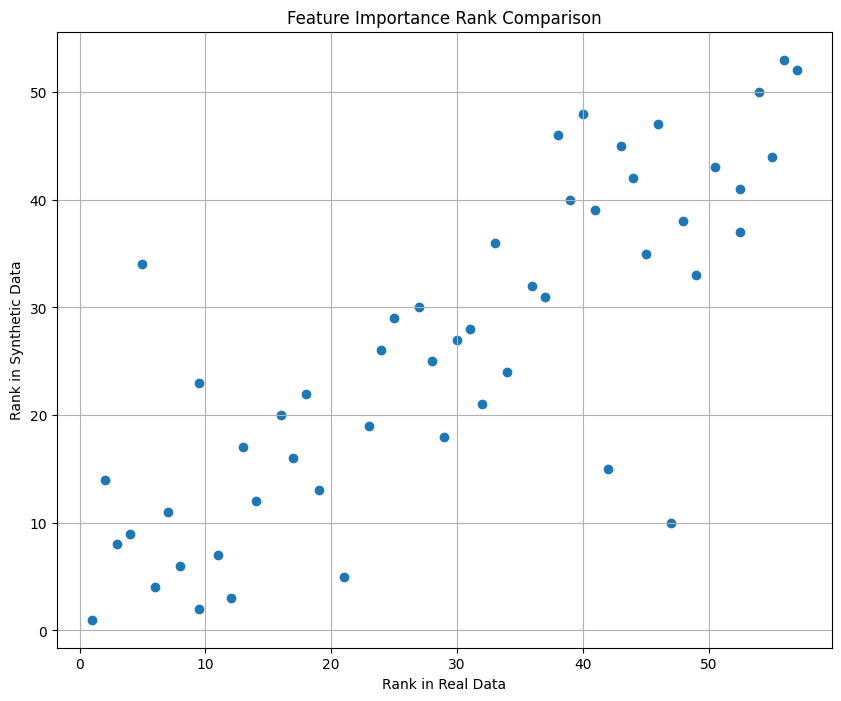

In [ ]:
import xgboost as xgb
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

# 실제 데이터셋으로 XGBoost 모델 학습
model_real = models_out['XGBoost']['real_model']

# 합성 데이터셋으로 XGBoost 모델 학습
model_synthetic = models_out['XGBoost']['syn_model']

# 실제 데이터셋에서의 피처 중요도
importance_real = model_real.get_booster().get_score(importance_type='weight')
importance_real_df = pd.DataFrame(list(importance_real.items()), columns=['Feature', 'Importance_Real'])

# 합성 데이터셋에서의 피처 중요도
importance_synthetic = model_synthetic.get_booster().get_score(importance_type='weight')
importance_synthetic_df = pd.DataFrame(list(importance_synthetic.items()), columns=['Feature', 'Importance_Synthetic'])

# 피처 중요도를 순위화
importance_real_df['Rank_Real'] = importance_real_df['Importance_Real'].rank(ascending=False)
importance_synthetic_df['Rank_Synthetic'] = importance_synthetic_df['Importance_Synthetic'].rank(ascending=False)

# 두 데이터프레임 병합 (모든 피처가 동일해야 함)
merged_df = pd.merge(importance_real_df, importance_synthetic_df, on='Feature', how='inner')

# 스피어만 순위 상관관계 계산
spearman_corr, _ = spearmanr(merged_df['Rank_Real'], merged_df['Rank_Synthetic'])
print(f"Spearman Rank Correlation: {spearman_corr:.4f}")

# 피처 중요도 비교 시각화
plt.figure(figsize=(10, 8))
plt.scatter(merged_df['Rank_Real'], merged_df['Rank_Synthetic'])
plt.title('Feature Importance Rank Comparison')
plt.xlabel('Rank in Real Data')
plt.ylabel('Rank in Synthetic Data')
plt.grid(True)
plt.show()


# 익명성 평가

In [ ]:
import numpy as np
import pandas as pd

# 실제 데이터 (Original Data)와 합성 데이터 (Synthetic Data)를 불러옵니다.
df_real = subset  # 원본 데이터
df_synth = syn_subset  # 합성 데이터

# 평가에 사용할 칼럼들
key_columns = ['Customer_Birthyear', 'Customer_Gender', 'Customer_credit_rating', 'Customer_identification_number', 'Location','IP_Address','MAC_Address', 'Customer_personal_identifier',
               'Transaction_Datetime', 'Account_account_number']
target_column = 'Fraud_Type'

# TCAP 계산 함수 정의
def calculate_tcap(df_real, df_synth, key_columns, target_column):
    n = len(df_real)
    numerator = 0
    denominator = 0

    for i in range(n):
        real_key = tuple(df_real[key_columns].iloc[i].values)
        synth_key = tuple(df_synth[key_columns].iloc[i].values)

        if real_key == synth_key:
            denominator += 1
            if df_real[target_column].iloc[i] == df_synth[target_column].iloc[i]:
                numerator += 1

    tcap_value = numerator / denominator if denominator != 0 else 0
    return tcap_value

# TCAP 계산
tcap_value = calculate_tcap(df_real, df_synth, key_columns, target_column)
print(f"TCAP Value: {tcap_value:.4f}")


TCAP Value: 0.0000
